In [1]:
# MODIFY! 
# use RobustScaler! 
model_name = 'RandFo'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/ul-pfe-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

## Determine Max Features

In [6]:
# MODIFY!
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(warm_start=True)
model

RandomForestRegressor(warm_start=True)

In [7]:
p_grid = {
    'max_features':['auto', 'sqrt', 'log2']
}

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=10, 
    verbose=1
)

In [10]:
grid_model.fit(X_train,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   31.2s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']},
             scoring='neg_mean_squared_error', verbose=1)

In [11]:
grid_model.best_params_

{'max_features': 'auto'}

In [12]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [13]:
hp

max_features    auto
Name: RandFo HP, dtype: object

In [14]:
hp.to_csv(f'./hyperparameters/{model_name}-hp.csv')

## Determine Number of Estimators

In [16]:
# MODIFY!
import time

estimators = [5,10,25,50,100,500,1000,2000]
scores_list = []

from sklearn.ensemble import RandomForestRegressor

for e in estimators: 
    start = time.time()
    print(f'Starting {e} estimators')
    score_model = RandomForestRegressor(
        n_estimators=e,
        max_features=grid_model.best_params_['max_features']
    )
    
    from sklearn.model_selection import cross_validate

    scores = cross_validate(
        score_model, 
        X_train, 
        y_train,
        scoring=[
            'neg_mean_absolute_error',
            'neg_mean_squared_error',
            'neg_root_mean_squared_error'
        ],
        cv=10
    )
    
    scores = pd.DataFrame(scores)
    scores
    mean_scores = scores.mean()
    scores_list.append(mean_scores)
    print(f'Done with {e} estimators')
    end = time.time()
    print(f'Elapsed time: {end - start}')
    print('\n')

Starting 5 estimators
Done with 5 estimators
Elapsed time: 1.3214120864868164


Starting 10 estimators
Done with 10 estimators
Elapsed time: 2.3994109630584717


Starting 25 estimators
Done with 25 estimators
Elapsed time: 11.256076097488403


Starting 50 estimators
Done with 50 estimators
Elapsed time: 13.466692924499512


Starting 100 estimators
Done with 100 estimators
Elapsed time: 26.217790842056274


Starting 500 estimators
Done with 500 estimators
Elapsed time: 118.80493211746216


Starting 1000 estimators
Done with 1000 estimators
Elapsed time: 229.708575963974


Starting 2000 estimators
Done with 2000 estimators
Elapsed time: 578.0545830726624




In [17]:
scores_df = pd.DataFrame(scores_list)

In [18]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.128193,0.002739,-2.970314,-17.543108,-4.178371
1,0.235732,0.003332,-2.931822,-16.770604,-4.085381
2,1.107047,0.015868,-2.801773,-15.678732,-3.948150
3,1.334818,0.009513,-2.766563,-15.240759,-3.887810
4,2.601423,0.017731,-2.738599,-14.842419,-3.839081
5,11.782848,0.084266,-2.739025,-14.922818,-3.849084
6,22.726268,0.221068,-2.735530,-14.871393,-3.842873
7,56.759501,0.975931,-2.733193,-14.811595,-3.834100


In [19]:
scores_df['Est'] = estimators

In [20]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,Est
0,0.128193,0.002739,-2.970314,-17.543108,-4.178371,5
1,0.235732,0.003332,-2.931822,-16.770604,-4.085381,10
2,1.107047,0.015868,-2.801773,-15.678732,-3.948150,25
3,1.334818,0.009513,-2.766563,-15.240759,-3.887810,50
4,2.601423,0.017731,-2.738599,-14.842419,-3.839081,100
5,11.782848,0.084266,-2.739025,-14.922818,-3.849084,500
6,22.726268,0.221068,-2.735530,-14.871393,-3.842873,1000
7,56.759501,0.975931,-2.733193,-14.811595,-3.834100,2000


# Export Scores for Number of Estimators

In [21]:
# mean_scores

In [22]:
scores_df = scores_df.rename(columns={
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [23]:
scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.128193,0.002739,-2.970314,-17.543108,-4.178371,5
1,0.235732,0.003332,-2.931822,-16.770604,-4.085381,10
2,1.107047,0.015868,-2.801773,-15.678732,-3.948150,25
3,1.334818,0.009513,-2.766563,-15.240759,-3.887810,50
4,2.601423,0.017731,-2.738599,-14.842419,-3.839081,100
5,11.782848,0.084266,-2.739025,-14.922818,-3.849084,500
6,22.726268,0.221068,-2.735530,-14.871393,-3.842873,1000
7,56.759501,0.975931,-2.733193,-14.811595,-3.834100,2000


In [24]:
scores_df[['MAE','MSE','RMSE']] = scores_df[['MAE','MSE','RMSE']].apply(lambda x : abs(x))

In [25]:
scores_df
# we go for 25 estimations. Note that from 25 -> 50 estimations the error metrics worsen

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.128193,0.002739,2.970314,17.543108,4.178371,5
1,0.235732,0.003332,2.931822,16.770604,4.085381,10
2,1.107047,0.015868,2.801773,15.678732,3.948150,25
3,1.334818,0.009513,2.766563,15.240759,3.887810,50
4,2.601423,0.017731,2.738599,14.842419,3.839081,100
5,11.782848,0.084266,2.739025,14.922818,3.849084,500
6,22.726268,0.221068,2.735530,14.871393,3.842873,1000
7,56.759501,0.975931,2.733193,14.811595,3.834100,2000


In [26]:
scores_df.to_csv(f'./scores/{model_name}-score.csv')

In [27]:
pct_scores_df = scores_df.pct_change()

In [28]:
pct_scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.838885,0.216509,-0.012959,-0.044035,-0.022255,1.0
2,3.696207,3.761626,-0.044358,-0.065106,-0.033591,1.5
3,0.205746,-0.400480,-0.012567,-0.027934,-0.015283,1.0
4,0.948897,0.863837,-0.010108,-0.026137,-0.012534,1.0
5,3.529386,3.752545,0.000155,0.005417,0.002606,4.0
6,0.928759,1.623448,-0.001276,-0.003446,-0.001614,1.0
7,1.497528,3.414615,-0.000854,-0.004021,-0.002283,1.0


In [29]:
pct_scores_df.style.background_gradient() 
# we choose index 4, 100 Estimations <- 
    # Score time decrease 3->4 & Score time increase dramatically 4->5
    # unsubstantial decrease MSE & RMSE 4->5 compared to 3->4

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,nan,nan,nan,nan,nan,nan
1,0.838885,0.216509,-0.012959,-0.044035,-0.022255,1.000000
2,3.696207,3.761626,-0.044358,-0.065106,-0.033591,1.500000
3,0.205746,-0.400480,-0.012567,-0.027934,-0.015283,1.000000
4,0.948897,0.863837,-0.010108,-0.026137,-0.012534,1.000000
5,3.529386,3.752545,0.000155,0.005417,0.002606,4.000000
6,0.928759,1.623448,-0.001276,-0.003446,-0.001614,1.000000
7,1.497528,3.414615,-0.000854,-0.004021,-0.002283,1.000000


# Score Model

In [30]:
# MODIFY!
# adopt number of estimators from the previous section

score_model = RandomForestRegressor(n_estimators=100)
score_model

RandomForestRegressor()

In [31]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [32]:
scores = pd.DataFrame(scores)

In [33]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,2.555543,0.016704,-2.754574,-15.257585,-3.906096
1,2.222908,0.017831,-2.648538,-14.002637,-3.742010
2,2.070483,0.016585,-2.641521,-14.386436,-3.792946
3,2.251624,0.015229,-2.884156,-15.091713,-3.884805
4,2.152272,0.014123,-3.044747,-20.528654,-4.530856
5,2.299549,0.021202,-2.458497,-10.983888,-3.314195
6,2.146433,0.016706,-2.920331,-15.963751,-3.995466
7,2.227369,0.021313,-2.674111,-13.354995,-3.654449
8,2.364990,0.017920,-2.480129,-12.009348,-3.465451
9,2.313748,0.022223,-2.877728,-17.768390,-4.215257


In [34]:
mean_scores = scores.mean()

In [35]:
mean_scores

fit_time                             2.260492
score_time                           0.017984
test_neg_mean_absolute_error        -2.738433
test_neg_mean_squared_error        -14.934740
test_neg_root_mean_squared_error    -3.850153
dtype: float64

# Export Scores

In [36]:
mean_scores = mean_scores.rename(f'{model_name}')

In [37]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [38]:
# mean_scores

In [39]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [40]:
mean_scores

Fit Time       2.260492
Score Time     0.017984
MAE            2.738433
MSE           14.934740
RMSE           3.850153
Name: RandFo, dtype: float64

In [41]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [42]:
mean_scores

Fit Time       2.260492
Score Time     0.017984
MAE            2.738433
MSE           14.934740
RMSE           3.850153
STD FT         0.135708
STD ST         0.002732
STD MAE        0.192789
STD MSE        2.755628
STD RMSE       0.351286
Name: RandFo, dtype: float64

In [43]:
mean_scores.to_csv(f'./scores/{model_name}-100-score.csv')

# Holdout Test

In [44]:
score_model.fit(X_train,y_train)

RandomForestRegressor()

In [45]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

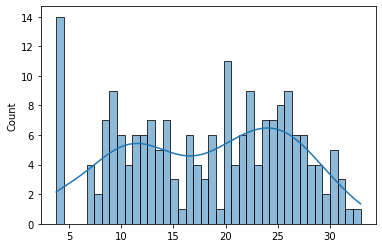

In [46]:
sns.histplot(y_holdout,bins=40,kde=True)

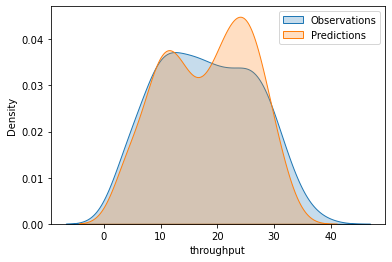

In [47]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

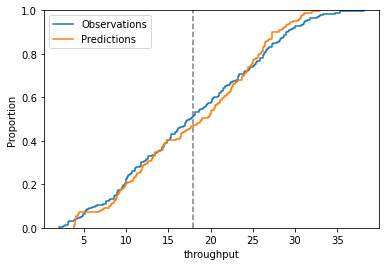

In [48]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [50]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,RandFo
MAE,2.891808
MSE,17.639584
RMSE,4.199950


In [51]:
err_df.to_csv(f'./holdout-test/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [52]:
res = y_test - y_holdout
res.describe().drop('count')

mean    -0.208438
std      4.205408
min    -11.771061
25%     -2.137424
50%     -0.086054
75%      1.754944
max     19.914228
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

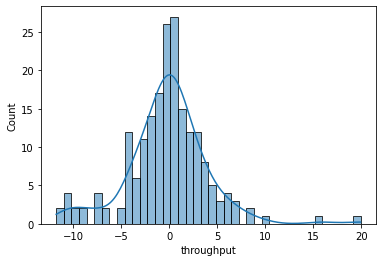

In [53]:
sns.histplot(data=res, kde=True,bins=40)

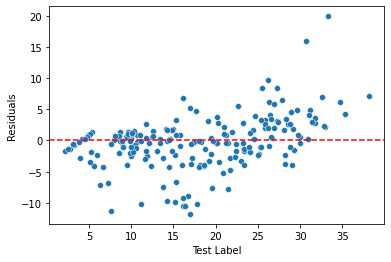

In [54]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

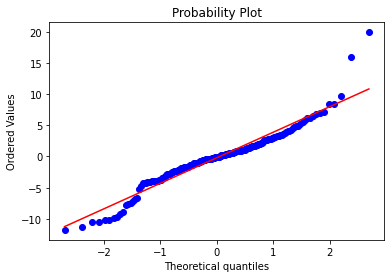

In [55]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [56]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [57]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

RandomForestRegressor()

In [58]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

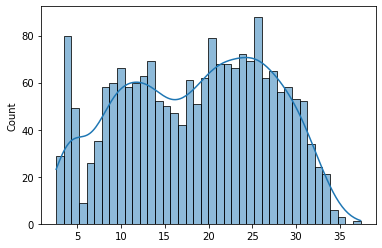

In [59]:
sns.histplot(y_pred,bins=40,kde=True)

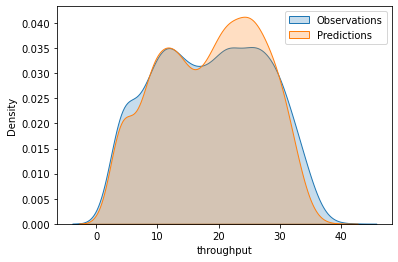

In [60]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

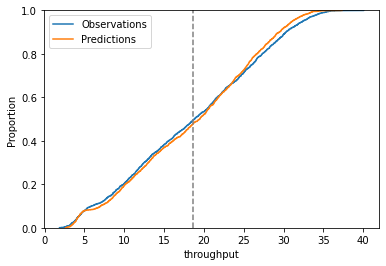

In [61]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [62]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [63]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,RandFo
MAE,1.010740
MSE,2.044441
RMSE,1.429840


In [64]:
err_df.to_csv(f'./model-err/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [65]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}-model.joblib')

['./opt-models/RandFo-model.joblib']

In [66]:
res = y - y_pred
res.describe().drop('count')

mean   -0.002790
std     1.430200
min    -8.193024
25%    -0.669966
50%     0.017962
75%     0.758684
max     7.404971
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

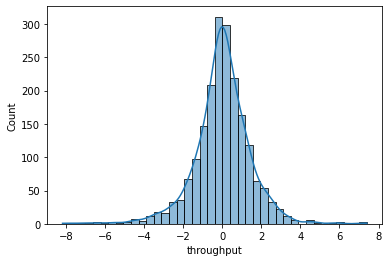

In [67]:
sns.histplot(data=res, kde=True,bins=40)

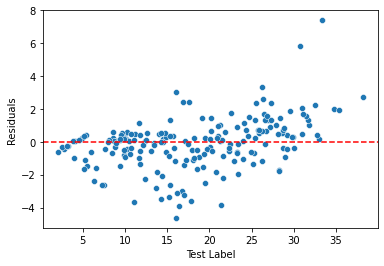

In [68]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

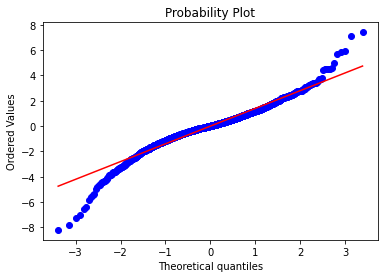

In [69]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!